# Sentiment Analysis Using TextBlob

## What is TextBlob?

TextBlob is an open-source Python library that performs NLP tasks. For a given input, it returns a polarity score between [-1.0 and 1.0], where -1.0 is negative, and 1.0 is positive.

Import necessary libraries

In [1]:
# Sentiment analyzer
from textblob import TextBlob

# Plotting data
import matplotlib.pyplot as plt

# Statistical analysis
import numpy as np
from scipy.stats import pearsonr, f_oneway

# File processing
import os



Declaration of universal constants

In [2]:
# album names -- in order of original release
ALBUMS = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "folklore", "evermore", "Midnights", "The Tortured Poets Department"]

# corresponding album shortenings -- used in data visualization for simplicity
SHORTENINGS = ["Debut", "Fearless", "Speak Now", 
          "Red", "1989", "rep", "Lover", 
          "folklore", "evermore", "Midnights", "TTPD"]

# number of songs per album
NUM_OF_SONGS = [14, 13, 16, 16, 13, 15, 18, 16, 15, 13, 16]

In [3]:
def getPolarity(lyrics : str) -> float:
    '''
    Description
    -----------
    Finds the polarity score for the lyrics

    Parameters
    ----------
    lyrics : str
        The lyrics for a particular song
    
    '''
    return TextBlob(lyrics).sentiment.polarity

In [4]:
def getAnalysis(score : float) -> int:
    '''
    Description
    -----------
    Determines if a polarity score corresponds to a positive, negative, or neutral song sentiment

    Parameters
    ----------
    score : float
        the raw score from getPolarity() for a song
        
    '''
    if score <= -0.01:
        return -1
    elif score >= 0.01:
        return 1
    else:
        return 0

In [5]:
def sentiment_lists(sentiment_class : dict[dict[str, int]]) -> list[float]:  
    '''
    Description
    -----------
    Returns a list of positive, negative, and neutral proportion per album

    
    Parameters
    ----------
    sentiment_class : dict[dict[str, int]]
        A dictionary that has a dictionary entry for each album, with keys and values corresponding to song name and score -1/0/1
        
    '''

    # List of number of positive songs across discography
    positives = []

    # List of number of negative songs across discography
    negatives = []

    # List of number of neutral songs across discography
    neutrals = []

    for album in ALBUMS:

        # Count of positive songs per album
        pos_counts = 0

        # Count of negative songs per album
        neg_counts = 0

        # Count of neutral songs per album
        neut_counts = 0

        for song in sentiment_class[album]:
            if sentiment_class[album][song] == 1:
                pos_counts += 1
            elif sentiment_class[album][song] == -1:
                neg_counts += 1
            else:
                neut_counts += 1
        
        # Append counts to lists
        positives.append(pos_counts)
        negatives.append(neg_counts)
        neutrals.append(neut_counts)
    
    # Recalculates negatives as a proportion of total songs per album
    for i, neg in enumerate(negatives):
        negatives[i] = neg / NUM_OF_SONGS[i]

    # Recalculates positives as a proportion of total songs per album
    for i, pos in enumerate(positives):
        positives[i] = pos / NUM_OF_SONGS[i]
    
    # Recalculates positives as a proportion of total songs per album
    for i, neut in enumerate(neutrals):
        neutrals[i] = neut / NUM_OF_SONGS[i]
    
    return positives, negatives, neutrals

In [6]:
def plot_data(positives : list[float], negatives : list[float], neutrals : list[float]):
    '''
    Description
    -----------
    Plots the sentiment data; can be modified if neutral songs are present in the dataset


    Parameters
    ----------
    positives : list[float]
        The proportion of positive songs per album
    negatives : list[float]
        The proportion of negative songs per album
    
    '''

    positives = np.array(positives)
    negatives = np.array(negatives)
    neutrals = np.array(neutrals)

    plt.figure(figsize=(20, 10))

    plt.bar(SHORTENINGS, negatives, color='peru', label='Negative')
    plt.bar(SHORTENINGS, neutrals, bottom = negatives, color = 'thistle', label = 'Neutral')
    plt.bar(SHORTENINGS, positives, bottom = negatives + neutrals, color='lightskyblue', label="Positive")

    plt.tick_params(axis="both", which='major', labelsize="16")

    plt.title("Change in Album Sentiment", fontsize='20')
    plt.xlabel("Album Title", fontsize='18')
    plt.ylabel("Album Sentiment", fontsize='18')

    plt.legend()
    plt.show()

Main function declaration

In [7]:
def main():
    '''
    Description
    -----------
    Driver function, runs the program

    '''

    # Dictionary that will keep track of sentiment scores per song per album
    sentiment_class = {}

    # Iterates over all songs (files) by album (dirs)
    for root, dirs, files in os.walk('songs_excl_ftv', topdown=True):

        for dir in dirs:

            # Creates a sub-dictionary that will track sentiment per song in an album
            sentiment_class[dir] = {}

            for file in os.listdir(os.path.join("songs_excl_ftv/", dir)):
                title = os.path.join(f"songs_excl_ftv/{dir}", file)
                
                with open(title) as t:
                    sentiment_class[dir][file[0:file.index(".")]] = {}
                    content = " ".join([line.rstrip('\n') for line in t])

                    # Calculates sentiment polarity for a document
                    sentiment = getPolarity(content)

                    # Determines if sentiment is negative, positive, or neutral
                    sentiment = getAnalysis(sentiment)

                    # Saves the calculated sentiment to the sentiment_class dictionary
                    sentiment_class[dir][file[0:file.index(".")]] = sentiment
    
    # Makes lists of all of the sentiments per album
    positives, negatives, neutrals = sentiment_lists(sentiment_class)

    # Plots the sentiment data
    plot_data(positives, negatives, neutrals)

    # Calculates the Pearson Correlation Coefficient
    correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), negatives)
    print("Correlation Coefficient:", correlation_coefficient)
    print("P-Value:", p_value)

    # Calculates the F-Stat for ANOVAs -- splits are done over genre distinctions
    country = [negatives[0], negatives[1], negatives[2]]
    country_to_pop = [negatives[3], negatives[4]]
    pop = [negatives[5], negatives[6]]
    experimental = [negatives[7],negatives[8],negatives[9],negatives[10]]

    f_stat, p_value = f_oneway(country, country_to_pop, pop, experimental)
    print("F-Stat:", f_stat)
    print("P-Value:", p_value)

    f_stat, p_value = f_oneway(country_to_pop, pop, experimental)
    print("Just Pop F-Stat:", f_stat)
    print("Just Pop P-Value:", p_value)
        


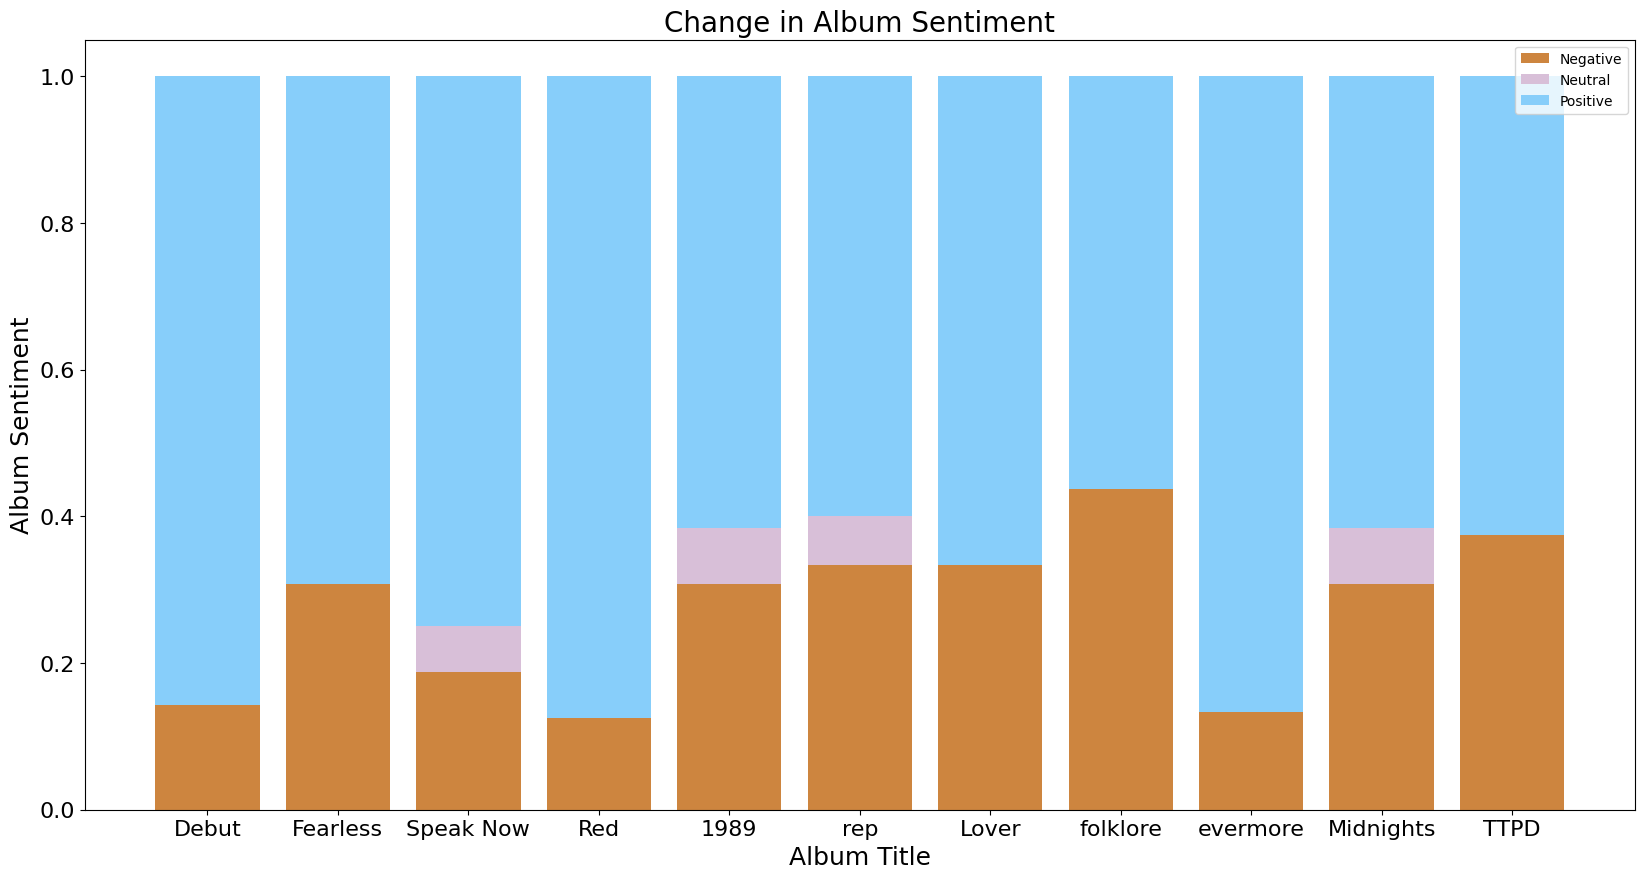

Correlation Coefficient: 0.5334401013503937
P-Value: 0.0910456995775955
F-Stat: 0.8762530500222021
P-Value: 0.49768680316928193
Just Pop F-Stat: 0.6093383772960794
Just Pop P-Value: 0.579668970923223


In [8]:
if __name__ == "__main__":
    main()